# Disease Detection from CT Scans by 3D CNN

In [1]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling3D, Input, ZeroPadding3D, BatchNormalization, MaxPooling3D, Concatenate, AveragePooling3D
from keras.layers.core import Dense, Activation, Dropout, Lambda
from keras.layers.convolutional import Conv3D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import multi_gpu_model
import tensorflow as tf

/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from importlib import reload
from sklearn.model_selection import train_test_split

In [3]:
#path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/CT_scans/'
path = '/nfs/turbo/umms-awaljee/wsliu/Data/CT_scans/'
model_path = path + 'models/'
if not os.path.exists(model_path): 
    os.mkdir(model_path)

In [4]:
batch_size = 2
G = 4

## Prepare Data Generators

In [5]:
df = pd.read_excel(path+'K23_Crohn_RadiologyReport_Labels_27MAR2018.xlsx')

df = df.dropna(subset=['StudyID'])

df['filename'] = ['s'+str(int(f)) for f in df['StudyID']]

df = df.drop_duplicates(subset=['filename'])

In [ ]:
df = pd.read_csv(path+'train_labels.csv')

In [8]:
df.columns

Index(['Database_ID', 'StudyID', 'Ileum', 'ascending', 'transverse',
       'Descending', 'Sigmoid', 'rectum', 'prox_small_bowel', 'Prox_Ileum',
       'Jejunum', 'Duodenum', 'Stomach', 'Esophagus', 'fistula_enteral',
       'fistula_perianal', 'abscess_enteral', 'abscess_perianal',
       'StrictureNoted', 'Bowel_Dilation_Noted', 'Lumen_Narrowing_Noted',
       'Prior_Surgery', 'Ostomy', 'Pouch', 'CD_Active_AnyLocation',
       'CD_Active_SmallBowel', 'CD_Active_RtColon', 'CD_Active_LtColon',
       'CD_Active_Pancolitis', 'Fistula_Any', 'Abscess_any',
       'Stricture_Suspected', 'Surgery_Prior_Any', 'filename'],
      dtype='object')

In [7]:
df.shape

(3477, 34)

In [16]:
df['CD_Active_AnyLocation'].value_counts(dropna=False)

1    2127
0    1353
Name: CD_Active_AnyLocation, dtype: int64

In [6]:
val_size = int(len(df)*0.125/8)*8

trn_size = int((len(df)-val_size)/8)*8

trn_df, val_df = train_test_split(df, test_size=val_size, train_size=trn_size, random_state=24, 
                                  stratify=df[['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any']])

In [8]:
trn_df, tst_df = train_test_split(df, test_size=0.2, stratify=df[['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any']], 
                                 random_state=24)

In [9]:
len(trn_df), len(val_df)

(2781, 696)

In [11]:
trn_df.to_csv(path+'train_labels.csv')
tst_df.to_csv(path+'test_labels.csv')

In [32]:
trn_df['Fistula_Any'].value_counts(dropna=False)

0    2387
1     397
Name: Fistula_Any, dtype: int64

In [10]:
tst_df['Abscess_any'].value_counts()

0    661
1     35
Name: Abscess_any, dtype: int64

In [7]:
import keras_addon
reload(keras_addon)
from keras_addon import ImageFrameGenerator

In [8]:
gen = ImageFrameGenerator()

In [9]:
trn_gen = gen.flow_from_frame(path+'ndarray/', trn_df, 'filename', ['Abscess_any'], 
                             target_size=(256, 256, 192), color_mode='3d', batch_size=batch_size*G)

Found 3474 images in the directory.
Using 2781 images to generate mini-batches.


In [10]:
val_gen = gen.flow_from_frame(path+'ndarray/', val_df, 'filename', ['Abscess_any'], 
                             target_size=(256, 256, 192), color_mode='3d', batch_size=batch_size*G)

Found 3474 images in the directory.
Using 688 images to generate mini-batches.


## Model Building

In [12]:
from dense3dnet import Dense3DNet

In [13]:
blocks = [6, 12, 24, 16]

In [37]:
with tf.device('/cpu:0'):
    base_model = Dense3DNet(blocks, pooling='avg')

    x = base_model.output
    #output_CD = Dense(1, activation='sigmoid', name='CD_Active_AnyLocation')(x)
    #output_fist = Dense(1, activation='sigmoid', name='Fistula_Any')(x)
    output_absc = Dense(1, activation='sigmoid', name='Abscess_any')(x)

    model = Model(inputs=base_model.input, outputs=output_absc)

In [39]:
parallel_model = multi_gpu_model(model, gpus=G)

In [40]:
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 192 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 256, 256, 192 0           input_4[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 256, 256, 192 0           input_4[0][0]                    
__________________________________________________________________________________________________
model_9 (Model)                 (None, 1)            1637497     lambda_5[0][0]                   
                                                                 lambda_6[0][0]                   
__________

In [17]:
parallel_model.compile(optimizer='adam', loss={'Abscess_any':'binary_crossentropy'}, metrics=['accuracy'])

In [15]:
parallel_model.compile(optimizer='adam', loss={'CD_Active_AnyLocation':'binary_crossentropy', 'Fistula_Any':'binary_crossentropy', 
                                     'Abscess_any':'binary_crossentropy'}, metrics=['accuracy'], 
             loss_weights={'CD_Active_AnyLocation':0.4, 'Fistula_Any':0.3, 'Abscess_any':0.3})

In [ ]:
hist = parallel_model.fit_generator(trn_gen, steps_per_epoch=trn_gen.n // (batch_size*G), epochs=3, validation_data=tst_gen, 
                    validation_steps=tst_gen.n // (batch_size*G))

Epoch 1/3
287/347 [=======================>......] - ETA: 4:06 - loss: 0.2644 - acc: 0.9294

## Result Evaluation

In [41]:
model.load_weights(model_path+'dense121_gr12_absc_f.h5')

In [12]:
tst_df = pd.read_csv(path+'test_labels.csv')

In [ ]:
gen = ImageFrameGenerator()
tst_itr =  gen.flow_from_frame(path+'ndarray/', tst_df, 'filename', ['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any'], 
                             target_size=(256, 256, 192), color_mode='3d', batch_size=batch_size*G, shuffle=False)

In [42]:
y = parallel_model.predict_generator(tst_itr, verbose=1)

172/172 [==============================] - 265s 2s/step


In [19]:
y_pred = np.concatenate(y, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [43]:
y_pred = y.reshape(y.shape[0])

In [35]:
y_true = tst_df[['CD_Active_AnyLocation', 'Fistula_Any', 'Abscess_any']].values

In [21]:
y_true = tst_df['Abscess_any'].values

In [27]:
from utils import plot_roc

{0: 0.45386129949682774}

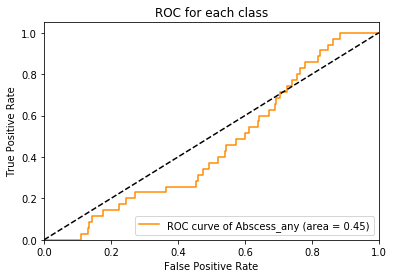

In [44]:
plot_roc(y_pred, y_true, classes=['Abscess_any'])

In [46]:
sum(y_pred>0.5)

2